### <b>Dataset Download</b>

* This facial identity classification dataset has total <b>307 identities</b> (train: 4,263 / test: 1,215).
* <b>Original dataset</b>: [CelebAMask-HQ](https://github.com/switchablenorms/CelebAMask-HQ)

<pre>
<b>Dataset/</b>
    <b>train/</b>
        identity 1/
        identity 2/
        ...
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

* Script for dataset download:

<pre>
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA?download=1 -O CelebA_HQ_facial_identity_dataset.zip
!unzip CelebA_HQ_facial_identity_dataset.zip -d ./CelebA_HQ_facial_identity_dataset
</pre>

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu") # device object

In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

data_dir = './CelebA_HQ_facial_identity_dataset'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 4263
Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '22

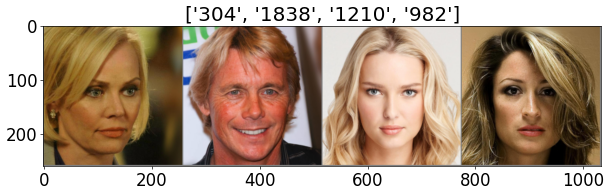

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(inputs, title):
    # torch.Tensor => numpy
    inputs = inputs.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inputs = std * inputs + mean
    inputs = np.clip(inputs, 0, 1)
    # display images
    plt.imshow(inputs)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Define Model</b>

* We focus on a transfer learning method.

In [4]:
model = models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

### <b>Training Phase</b>


In [5]:
num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

/home/dongbin/mine/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Train #0] Loss: 5.9747 Acc: 2.6507% Time: 22.6714s
[Test #0] Loss: 5.2459 Acc: 4.6914% Time: 28.9523s
[Train #1] Loss: 4.1008 Acc: 16.3500% Time: 51.6019s
[Test #1] Loss: 3.8193 Acc: 20.6584% Time: 57.9908s
[Train #2] Loss: 2.4220 Acc: 45.1795% Time: 80.5727s
[Test #2] Loss: 2.9969 Acc: 33.2510% Time: 87.0091s
[Train #3] Loss: 1.2376 Acc: 71.0063% Time: 109.5290s
[Test #3] Loss: 1.9560 Acc: 52.5103% Time: 116.2148s
[Train #4] Loss: 0.5594 Acc: 88.7872% Time: 138.5023s
[Test #4] Loss: 1.8666 Acc: 55.4733% Time: 144.7622s
[Train #5] Loss: 0.2372 Acc: 96.5517% Time: 167.0329s
[Test #5] Loss: 1.1402 Acc: 74.3210% Time: 173.3702s
[Train #6] Loss: 0.0801 Acc: 99.4370% Time: 195.7843s
[Test #6] Loss: 0.8237 Acc: 81.1523% Time: 202.6047s
[Train #7] Loss: 0.0429 Acc: 99.8123% Time: 225.3058s
[Test #7] Loss: 0.7409 Acc: 83.5391% Time: 231.8404s
[Train #8] Loss: 0.0302 Acc: 99.7654% Time: 254.3380s
[Test #8] Loss: 0.7003 Acc: 83.2099% Time: 260.8092s
[Train #9] Loss: 0.0121 Acc: 99.9765% Time: 2

### <b>Final Test Phase</b>

* Save the trained model file.

In [6]:
save_path = 'facial_identity_classification_using_transfer_learning_with_DenseNet121_resolution_256_normalize_05.pth'
torch.save(model.state_dict(), save_path)

* Load from the trained model file.

In [7]:
model = models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model.load_state_dict(torch.load(save_path))
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

* Evaluate the trained model.

[Original Image Examples]


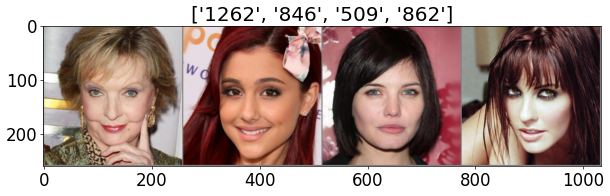

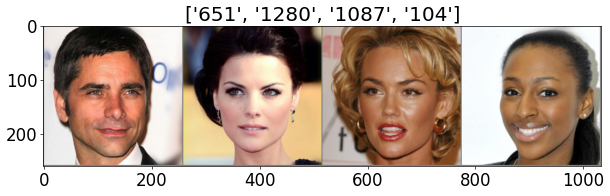

[Prediction Result Examples]


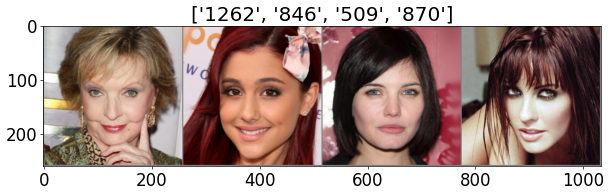

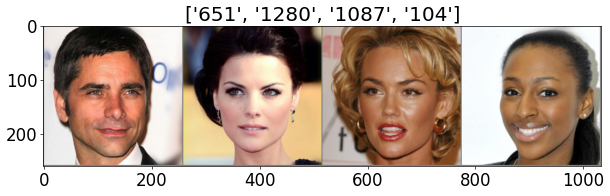

[Test #29] Loss: 0.5851 Acc: 86.4198% Time: 6.5984s


In [8]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in preds[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))